# Visualization of the number of different Police Stations

In [3]:
# Import basic functionality
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
import re
import os
# Import the required library
!pip install geopy
from geopy.geocoders import Nominatim

In [4]:
# Read the data
sentencing_cleaned = pd.read_csv("/Users/leowu/Desktop/Study_Materials/Data_Science1/pset2_inputdata/sentencing_cleaned.csv")
police_stations = pd.read_csv('/Users/leowu/Desktop/Final-Project-Group5/Dataset/Police_Stations.csv')

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_16880/3056575544.py:2: DtypeWarning: Columns (10,11,16,25) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
# Get the head of the data
sentencing_cleaned.head()

CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0  149765331439         175691153649  8/15/1984 12:00:00 AM   
1  150065796098         162105612284  8/23/1984 12:00:00 AM   
2  154954734978         225758446387   6/8/2001 12:00:00 AM   
3  155222744754         217349881776  1/31/2001 12:00:00 AM   
4  155327892699         217212381455   2/6/2001 12:00:00 AM   

    OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG    CHARGE_ID  CHARGE_VERSION_ID  \
0  PROMIS Conversion                 True  50510062193       112898098217   
1  PROMIS Conversion                 True  50792360681       113332130159   
2  PROMIS Conversion                 True  54885211141       174293345821   
3  PROMIS Conversion                 True  53899906462       280120721775   
4  PROMIS Conversion                 True  53938518259       164877860811   

                   DISPOSITION_CHARGED_OFFENSE_TITLE  CHARGE_COUNT  \
0                                FIRST DEGREE MURDER             1   
1                                FIRST DEGREE MURDER             1   
2                              VIO BAIL BOND/CLASS 1             1   
3                    POSS AMT CON SUB EXCEPT (A)/(D)             1   
4  DUI LIC SUSPENDED OR REVOKED (EFFECTIVE 4-13-2...             1   

         DISPOSITION_DATE  ... simplified_offense_derived is_black_derived  \
0  12/17/2014 12:00:00 AM  ...                   Homicide             True   
1    8/6/2014 12:00:00 AM  ...                   Homicide             True   
2   12/2/2013 12:00:00 AM  ...          PROMIS Conversion            False   
3   9/10/2012 12:00:00 AM  ...                  Narcotics             True   
4   9/19/2014 12:00:00 AM  ...          PROMIS Conversion            False   

  is_hisp_derived is_white_derived is_other_derived is_male_derived  \
0           False            False            False            True   
1           False            False            False            True   
2            True            False            False            True   
3           False            False            False           False   
4           False             True            False            True   

  age_derived sentenceymd_derived sentenceym_derived judgeid_derived  
0        27.0          2014-10-16         2014-10-01        judge_40  
1        30.0          2014-08-06         2014-08-01       judge_310  
2        38.0          2013-12-02         2013-12-01       judge_162  
3        33.0          2012-09-10         2012-09-01       judge_331  
4        49.0          2014-09-19         2014-09-01       judge_314  

[5 rows x 52 columns]

### Exploring the Distribution of Categories in High Cardinality Variables
An important thing to understand about this categorical data is that there are a very large number of categories in many columns, but that there are also a much smaller set of categories that are reported with significant frequency. Let's take a look at the function written to count these:

In [158]:
# check categorical distribution
def check_cat_dist(data, col_name, thresh=.1, top_n=25):
    '''fraction of data in levels that represent less than 10% of total'''
    freqs = data[col_name].value_counts()
    
    # percent of data represented by categories with x members
    frac_by_freq = freqs.groupby(freqs).sum()/data.shape[0] 
    thresh = data.shape[0]*thresh
    mask = frac_by_freq.index < thresh
    
     # percent of data in categories that each represent less than 10% of all obs
    frac_below_thresh = frac_by_freq[mask].sum()
    
    # number of categories which have more than thresh % (e.g. 10%) of data in them
    num_above_thresh = (~mask).sum() 
    frac_top_n = freqs[:top_n].sum()/data.shape[0]
    return frac_below_thresh, num_above_thresh, frac_top_n

In [159]:
# look at distribution of obs across categories
thresh = .05
top_n=73
for i in sentencing_cleaned.select_dtypes('object').columns:
    print(i)
    a,b,c = check_cat_dist(sentencing_cleaned, i, thresh, top_n)
    print(f'{sentencing_cleaned[i].unique().shape[0]} categories')
    print(f'{round(a*100,3)}% of categories have less than {thresh*100}% of the data in them')
    print(f'{b} categories have more than {thresh*100}% of the data in them')
    print(f'{round(c*100,3)}% of the data is in the most frequent {top_n} categories', '\n')

RECEIVED_DATE
4978 categories
100.0% of categories have less than 5.0% of the data in them
0 categories have more than 5.0% of the data in them
4.527% of the data is in the most frequent 73 categories 

OFFENSE_CATEGORY
87 categories
36.765% of categories have less than 5.0% of the data in them
6 categories have more than 5.0% of the data in them
99.904% of the data is in the most frequent 73 categories 

DISPOSITION_CHARGED_OFFENSE_TITLE
1163 categories
62.129% of categories have less than 5.0% of the data in them
4 categories have more than 5.0% of the data in them
91.661% of the data is in the most frequent 73 categories 

DISPOSITION_DATE
2689 categories
100.0% of categories have less than 5.0% of the data in them
0 categories have more than 5.0% of the data in them
5.925% of the data is in the most frequent 73 categories 

DISPOSITION_CHARGED_CHAPTER
221 categories
7.163% of categories have less than 5.0% of the data in them
3 categories have more than 5.0% of the data in them
99.

### Add neighborhoods to the police station df

In [6]:
police_stations['NEIGHBORHOODS'] = ['Douglas','Near North Side','Lake View','Lincoln Square','Morgan Park',\
                                   'Rogers Park','Belmont Cragin','Near South Side','Fuller Park',\
                                   'Woodlawn','South Deering','Pullman','Auburn Gresham','West Englewood',\
                                   'Chicago Lawn','Bridgeport','North Lawndale','East Garfield Park',\
                                   'Near West Side','Logan Square','Austin','Jefferson Park','Jefferson Park']

In [7]:
police_stations.head()

DISTRICT DISTRICT NAME              ADDRESS     CITY STATE    ZIP  \
0  Headquarters  Headquarters  3510 S Michigan Ave  Chicago    IL  60653   
1            18    Near North   1160 N Larrabee St  Chicago    IL  60610   
2            19     Town Hall     850 W Addison St  Chicago    IL  60613   
3            20       Lincoln   5400 N Lincoln Ave  Chicago    IL  60625   
4            22   Morgan Park  1900 W Monterey Ave  Chicago    IL  60643   

                                             WEBSITE         PHONE  \
0                      http://home.chicagopolice.org           NaN   
1  http://home.chicagopolice.org/community/distri...  312-742-5870   
2  http://home.chicagopolice.org/community/distri...  312-744-8320   
3  http://home.chicagopolice.org/community/distri...  312-742-8714   
4  http://home.chicagopolice.org/community/distri...  312-745-0710   

            FAX           TTY  X COORDINATE  Y COORDINATE   LATITUDE  \
0           NaN           NaN   1177731.401   1881697.404  41.830702   
1  312-742-5771  312-742-5773   1172080.029   1908086.527  41.903242   
2  312-744-4481  312-744-8011   1169730.744   1924160.317  41.947400   
3  312-742-8803  312-742-8841   1158399.146   1935788.826  41.979550   
4  312-745-0814  312-745-0569   1165825.476   1830851.333  41.691435   

   LONGITUDE                         LOCATION    NEIGHBORHOODS  
0 -87.623395  (41.8307016873, -87.6233953459)          Douglas  
1 -87.643352  (41.9032416531, -87.6433521393)  Near North Side  
2 -87.651512   (41.9474004564, -87.651512018)        Lake View  
3 -87.692845  (41.9795495131, -87.6928445094)   Lincoln Square  
4 -87.668520  (41.6914347795, -87.6685203937)      Morgan Park

In [8]:
new_df = sentencing_cleaned[~sentencing_cleaned['LAW_ENFORCEMENT_UNIT'].isnull()]

In [9]:
new_df_count = new_df.groupby('LAW_ENFORCEMENT_UNIT').agg(COUNT = ('CASE_ID','count')).\
sort_values('COUNT',ascending = False).reset_index()

In [10]:
new_df_count.head()

LAW_ENFORCEMENT_UNIT  COUNT
0  District 11 - Harrison  10328
1     District 10 - Ogden   3393
2    District 15 - Austin   3178
3  District 7 - Englewood   2639
4    District 6 - Gresham   2329

In [11]:
new_df_up = new_df_count[new_df_count.LAW_ENFORCEMENT_UNIT.str.contains('District')].reset_index().drop(columns=['index'])

In [12]:
new_df_up['DISTRICT NAME'] = [new_df_up.LAW_ENFORCEMENT_UNIT.str.split(' - ')[i][1] for i in range(len(new_df_up))]

In [13]:
new_df_up.head()

LAW_ENFORCEMENT_UNIT  COUNT DISTRICT NAME
0  District 11 - Harrison  10328      Harrison
1     District 10 - Ogden   3393         Ogden
2    District 15 - Austin   3178        Austin
3  District 7 - Englewood   2639     Englewood
4    District 6 - Gresham   2329       Gresham

In [14]:
new_df_con = pd.merge(new_df_up,
                     police_stations[['DISTRICT NAME','LATITUDE','LONGITUDE','NEIGHBORHOODS']],
                     how = 'inner',
                     on = 'DISTRICT NAME')

In [15]:
new_df_con.head()

LAW_ENFORCEMENT_UNIT  COUNT DISTRICT NAME   LATITUDE  LONGITUDE  \
0  District 11 - Harrison  10328      Harrison  41.873582 -87.705488   
1     District 10 - Ogden   3393         Ogden  41.856685 -87.708382   
2    District 15 - Austin   3178        Austin  41.880083 -87.768200   
3  District 7 - Englewood   2639     Englewood  41.779632 -87.660887   
4    District 6 - Gresham   2329       Gresham  41.752137 -87.644229   

        NEIGHBORHOODS  
0  East Garfield Park  
1      North Lawndale  
2              Austin  
3      West Englewood  
4      Auburn Gresham

### Visualize the total number of crimes in the region

In [14]:
# Import folium package
import folium
from folium import plugins

# Illinois latitude and longitude values
latitude = 41.9811
longitude = -89.5951

# let's start again with a clean copy of the map of Illinois
ill_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(ill_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(new_df_con.LATITUDE, new_df_con.LONGITUDE, new_df_con.COUNT):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# add incidents to map
ill_map.add_child(incidents)

### Read the geojson file to visualize the boundaries of the different neighborhoods in the city of Chicago 

In [16]:
!pip install geojson
import geojson
with open('/Users/leowu/Desktop/Final-Project-Group5/Dataset/Boundaries - Neighborhoods.geojson') as f:
    chi_geo = geojson.load(f)

In [17]:
chi_map = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.GeoJson(
    chi_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }
).add_to(chi_map)

#display map
chi_map

### Create a Choropleth Map (color indicates the number of crime incidents in each district)

In [18]:
new_con = new_df_con.groupby('NEIGHBORHOODS').agg(SUM = ('COUNT','sum')).\
sort_values('SUM',ascending = False).reset_index()

In [19]:
new_con.head()

NEIGHBORHOODS    SUM
0  East Garfield Park  10328
1      North Lawndale   3393
2              Austin   3178
3      West Englewood   2639
4      Auburn Gresham   2329

In [20]:
m = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Choropleth(
    geo_data=chi_geo,
    data=new_con,
    columns=['NEIGHBORHOODS','SUM'],
    key_on='properties.pri_neigh',
    #fill_color='red',
    fill_color='YlOrRd',
    fill_opacity=0.2,
    line_opacity=0.4,
    highlight=True,
    legend_name='Crime Counts in Chicago'
).add_to(m)
m

### Create HeatMap

In [21]:
from folium.plugins import HeatMap

# let's start again with a clean copy of the map of San Francisco
chi_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# Convert data format
data=new_con
heatdata = new_df_con[['LATITUDE','LONGITUDE']].values.tolist()

# add incidents to map
HeatMap(heatdata).add_to(chi_map)

chi_map

# Add more variables such as gender of judges, COVID-19, livability

## Guess the gender of judges, and add is_judge_male column

In [22]:
!pip install gender_guesser
!pip install xlrd
!pip install openpyxl

import gender_guesser.detector as gender

In [23]:
sentencing_cleaned['SENTENCE_JUDGE'].head()

0       Clayton Jay Crane
1         Thomas V Gainer
2            Kay M Hanlon
3        William J Kunkle
4    Timothy Joseph Joyce
Name: SENTENCE_JUDGE, dtype: object

In [24]:
# Get the first name of judgers
sentencing_cleaned['FN_judge'] = [i.split(' ')[0] for i in sentencing_cleaned['SENTENCE_JUDGE']]

In [25]:
sentencing_cleaned['FN_judge'].head()

0    Clayton
1     Thomas
2        Kay
3    William
4    Timothy
Name: FN_judge, dtype: object

In [26]:
# Predict the judgers' genders
gd = gender.Detector()
sentencing_cleaned['Gender_judge'] = sentencing_cleaned['FN_judge'].apply(str.capitalize).map(lambda x: gd.get_gender(x))

In [27]:
# Get the first 20 predicted genders
sentencing_cleaned[['FN_judge','Gender_judge']].head()

FN_judge Gender_judge
0  Clayton         male
1   Thomas         male
2      Kay         male
3  William         male
4  Timothy         male

In [28]:
# To see the diffence of judge made by judgers with different genders
sentencing_cleaned.groupby('Gender_judge').agg(num_judge = ('Gender_judge', 'count')).reset_index()

Gender_judge  num_judge
0           andy         98
1         female      33910
2           male      87835
3  mostly_female       9680
4    mostly_male          1
5        unknown       3641

In [29]:
# Rename the is_judge_gender
sentencing_cleaned1 = sentencing_cleaned[sentencing_cleaned.Gender_judge.isin(['female','male',\
                                                                               'mostly_female','mostly_male'])]
sentencing_cleaned1['is_judge_male'] = np.where(sentencing_cleaned1.Gender_judge.isin(['mostly_male','male']), True, False)

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_8346/391556450.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
sentencing_cleaned1[['is_judge_male','Gender_judge']].head()

is_judge_male Gender_judge
0           True         male
1           True         male
2           True         male
3           True         male
4           True         male

## Add a variable called is_covid to research the influence of covid
We select 2020 as the seperate line, <2020 is False, >=2020 is True

In [31]:
sentencing_cleaned1["ARREST_DATE"].head()

0     8/15/1984 12:00:00 AM
1     2/10/1983 12:00:00 AM
2    10/26/2000 12:00:00 AM
3      1/30/2001 2:10:00 AM
4      1/14/2001 6:45:00 PM
Name: ARREST_DATE, dtype: object

In [32]:
# Use regex to clean up the date columns
sentencing_cleaned1["ARREST_DATE"]  = [re.sub(r'2[1-9]([0-9]+)', r"20\1", str(date)) 
                                               if bool(re.search('\/2[1-9][0-9]+', str(date))) else 
                                               str(date) 
                                               for date in 
                                               sentencing_cleaned1["ARREST_DATE"]]
sentencing_cleaned1["ARREST_DATE"].head()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_8346/1805039885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0     8/15/1984 12:00:00 AM
1     2/10/1983 12:00:00 AM
2    10/26/2000 12:00:00 AM
3      1/30/2001 2:10:00 AM
4      1/14/2001 6:45:00 PM
Name: ARREST_DATE, dtype: object

In [33]:
# Transfer date to datetime 
sentencing_cleaned1["ARREST_DATE"] = pd.to_datetime(sentencing_cleaned1.ARREST_DATE)                                                  
sentencing_cleaned1["ARREST_DATE"].head()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_8346/4269650148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0   1984-08-15 00:00:00
1   1983-02-10 00:00:00
2   2000-10-26 00:00:00
3   2001-01-30 02:10:00
4   2001-01-14 18:45:00
Name: ARREST_DATE, dtype: datetime64[ns]

In [34]:
sentencing_cleaned1["arrest_year"] = sentencing_cleaned1["ARREST_DATE"].dt.year
sentencing_cleaned1["arrest_year"].head()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_8346/2658925552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    1984.0
1    1983.0
2    2000.0
3    2001.0
4    2001.0
Name: arrest_year, dtype: float64

In [35]:
sentencing_cleaned1["is_covid"] = np.where(sentencing_cleaned1["arrest_year"]>=2020 , True, False)
sentencing_cleaned1["is_covid"].head()

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_8346/844829083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    False
1    False
2    False
3    False
4    False
Name: is_covid, dtype: bool

## Add livability index
Livability from website: https://www.areavibes.com/

In [17]:
new_df_con['Livability'] = [62, 51, 60, 56, 58, 64, 58, 56, 66, 55, 54, 57, 63, 68, 73, 73, 55, 63, 76, 76, 67, 69]
new_df_con

LAW_ENFORCEMENT_UNIT  COUNT   DISTRICT NAME   LATITUDE  LONGITUDE  \
0         District 11 - Harrison  10328        Harrison  41.873582 -87.705488   
1            District 10 - Ogden   3393           Ogden  41.856685 -87.708382   
2           District 15 - Austin   3178          Austin  41.880083 -87.768200   
3         District 7 - Englewood   2639       Englewood  41.779632 -87.660887   
4           District 6 - Gresham   2329         Gresham  41.752137 -87.644229   
5    District 25 - Grand Central   2257   Grand Central  41.918609 -87.765574   
6      District 8 - Chicago Lawn   1787    Chicago Lawn  41.778987 -87.708864   
7           District 5 - Calumet   1764         Calumet  41.692723 -87.604506   
8           District 9 - Deering   1590         Deering  41.837394 -87.646408   
9    District 3 - Grand Crossing   1467  Grand Crossing  41.766431 -87.605748   
10    District 4 - South Chicago   1424   South Chicago  41.707933 -87.568349   
11        District 2 - Wentworth   1074       Wentworth  41.801811 -87.630560   
12      District 18 - Near North    891      Near North  41.903242 -87.643352   
13     District 22 - Morgan Park    777     Morgan Park  41.691435 -87.668520   
14       District 19 - Town Hall    722       Town Hall  41.947400 -87.651512   
15       District 23 - Town Hall     49       Town Hall  41.947400 -87.651512   
16          District 1 - Central    675         Central  41.858373 -87.627356   
17     District 14 - Shakespeare    627     Shakespeare  41.921103 -87.697452   
18  District 16 - Jefferson Park    621  Jefferson Park  41.974094 -87.766149   
19     District 17 - Albany Park    581     Albany Park  41.966053 -87.728115   
20     District 24 - Rogers Park    556     Rogers Park  41.999763 -87.671324   
21         District 20 - Lincoln    385         Lincoln  41.979550 -87.692845   

         NEIGHBORHOODS  Livability  
0   East Garfield Park          62  
1       North Lawndale          51  
2               Austin          60  
3       West Englewood          56  
4       Auburn Gresham          58  
5       Belmont Cragin          64  
6         Chicago Lawn          58  
7              Pullman          56  
8           Bridgeport          66  
9             Woodlawn          55  
10       South Deering          54  
11         Fuller Park          57  
12     Near North Side          63  
13         Morgan Park          68  
14           Lake View          73  
15           Lake View          73  
16     Near South Side          55  
17        Logan Square          63  
18      Jefferson Park          76  
19      Jefferson Park          76  
20         Rogers Park          67  
21      Lincoln Square          69

### Merge these two dataframes together

In [37]:
sentencing_cleaned2 = sentencing_cleaned1[(~sentencing_cleaned1.LAW_ENFORCEMENT_UNIT.isnull())&
                                         (~sentencing_cleaned1.arrest_year.isna())]
sentencing_conc = pd.merge(sentencing_cleaned2,
                            new_df_con[['Livability','LAW_ENFORCEMENT_UNIT']],
                            how='inner',
                            on='LAW_ENFORCEMENT_UNIT')
sentencing_conc.head()

CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0  377339554790         694908976813  4/20/2010 12:00:00 AM   
1  377483178659         695319307216  4/25/2010 12:00:00 AM   
2  378092331838         697088125695  5/19/2010 12:00:00 AM   
3  378609260283         698663575500  6/14/2010 12:00:00 AM   
4  379857965557         702470456396  8/11/2010 12:00:00 AM   

       OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG     CHARGE_ID  CHARGE_VERSION_ID  \
0  Residential Burglary                 True  333678120296       620028456139   
1   Vehicular Hijacking                 True  333898177372       657484590678   
2             Narcotics                 True  335399060145       623393931974   
3             Narcotics                 True  336236855694       624986192074   
4              Burglary                 True  337103911746       626633943991   

                   DISPOSITION_CHARGED_OFFENSE_TITLE  CHARGE_COUNT  \
0                               RESIDENTIAL BURGLARY             1   
1                                      ARMED ROBBERY             1   
2  [POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...             1   
3               POSSESSION OF A CONTROLLED SUBSTANCE             1   
4                                           BURGLARY             1   

        DISPOSITION_DATE  ... age_derived sentenceymd_derived  \
0  8/17/2014 12:00:00 AM  ...        20.0          2014-08-17   
1  1/20/2012 12:00:00 AM  ...        18.0          2012-01-20   
2  7/10/2012 12:00:00 AM  ...        38.0          2012-07-10   
3  2/27/2012 12:00:00 AM  ...        23.0          2012-02-27   
4   2/8/2012 12:00:00 AM  ...        24.0          2012-02-08   

  sentenceym_derived judgeid_derived  FN_judge Gender_judge is_judge_male  \
0         2014-08-01       judge_279   Shelley       female         False   
1         2012-01-01       judge_334   William         male          True   
2         2012-07-01       judge_178  Lawrence         male          True   
3         2012-02-01       judge_279   Shelley       female         False   
4         2012-02-01       judge_275    Sharon       female         False   

  arrest_year is_covid Livability  
0      2010.0    False         76  
1      2010.0    False         76  
2      2010.0    False         76  
3      2010.0    False         76  
4      2010.0    False         76  

[5 rows x 58 columns]

## Add Arrest police station history record index
In detailed, it refers to the proportion of different police station history record number

In [38]:
new_df_con['his_prop'] = new_df_con.COUNT / new_df_con.COUNT.sum()

In [39]:
new_df_con.head()

LAW_ENFORCEMENT_UNIT  COUNT DISTRICT NAME   LATITUDE  LONGITUDE  \
0  District 11 - Harrison  10328      Harrison  41.873582 -87.705488   
1     District 10 - Ogden   3393         Ogden  41.856685 -87.708382   
2    District 15 - Austin   3178        Austin  41.880083 -87.768200   
3  District 7 - Englewood   2639     Englewood  41.779632 -87.660887   
4    District 6 - Gresham   2329       Gresham  41.752137 -87.644229   

        NEIGHBORHOODS  Livability  his_prop  
0  East Garfield Park          62  0.264049  
1      North Lawndale          51  0.086746  
2              Austin          60  0.081250  
3      West Englewood          56  0.067469  
4      Auburn Gresham          58  0.059544

In [40]:
sentencing_conc = pd.merge(sentencing_conc,
                            new_df_con[['his_prop','LAW_ENFORCEMENT_UNIT']],
                            how='inner',
                            on='LAW_ENFORCEMENT_UNIT')

In [41]:
sentencing_conc.head()

CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0  377339554790         694908976813  4/20/2010 12:00:00 AM   
1  377483178659         695319307216  4/25/2010 12:00:00 AM   
2  378092331838         697088125695  5/19/2010 12:00:00 AM   
3  378609260283         698663575500  6/14/2010 12:00:00 AM   
4  379857965557         702470456396  8/11/2010 12:00:00 AM   

       OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG     CHARGE_ID  CHARGE_VERSION_ID  \
0  Residential Burglary                 True  333678120296       620028456139   
1   Vehicular Hijacking                 True  333898177372       657484590678   
2             Narcotics                 True  335399060145       623393931974   
3             Narcotics                 True  336236855694       624986192074   
4              Burglary                 True  337103911746       626633943991   

                   DISPOSITION_CHARGED_OFFENSE_TITLE  CHARGE_COUNT  \
0                               RESIDENTIAL BURGLARY             1   
1                                      ARMED ROBBERY             1   
2  [POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...             1   
3               POSSESSION OF A CONTROLLED SUBSTANCE             1   
4                                           BURGLARY             1   

        DISPOSITION_DATE  ... sentenceymd_derived sentenceym_derived  \
0  8/17/2014 12:00:00 AM  ...          2014-08-17         2014-08-01   
1  1/20/2012 12:00:00 AM  ...          2012-01-20         2012-01-01   
2  7/10/2012 12:00:00 AM  ...          2012-07-10         2012-07-01   
3  2/27/2012 12:00:00 AM  ...          2012-02-27         2012-02-01   
4   2/8/2012 12:00:00 AM  ...          2012-02-08         2012-02-01   

  judgeid_derived  FN_judge Gender_judge is_judge_male arrest_year is_covid  \
0       judge_279   Shelley       female         False      2010.0    False   
1       judge_334   William         male          True      2010.0    False   
2       judge_178  Lawrence         male          True      2010.0    False   
3       judge_279   Shelley       female         False      2010.0    False   
4       judge_275    Sharon       female         False      2010.0    False   

  Livability  his_prop  
0         76  0.015877  
1         76  0.015877  
2         76  0.015877  
3         76  0.015877  
4         76  0.015877  

[5 rows x 59 columns]

## Add senlength (unit: year) variable

In [42]:
sentencing_conc = sentencing_conc[(~sentencing_conc.COMMITMENT_TERM.isna())
                                     & (sentencing_conc.COMMITMENT_UNIT.isin(['Days','Hours','Year(s)','Months','Weeks','Natural Life']))]

In [43]:
# Change the units to year
def transition(df: pd.DataFrame):
    df['senlength_derived'] = [float(u)
      if v == 'Year(s)'
      else float(float(u) / (24*365)) 
           if v == 'Hours'
           else float(float(u)/ 365) 
                if v == 'Days'
                else float(float(u)/ 12) 
                    if v == 'Months'
                    else float(float(u) *7 / 365) 
                        if v == 'Weeks'
                        else float(100-20)
                               if (v == 'Natural Life') & (np.isnan(i))
                               else float(100-float(i)) 
      for u,v,i in zip(df.COMMITMENT_TERM,df.COMMITMENT_UNIT,df.age_derived)]
    
    return df

In [44]:
sentencing_conc1 = transition(df = sentencing_conc)
sentencing_conc1.head()

CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0  377339554790         694908976813  4/20/2010 12:00:00 AM   
1  377483178659         695319307216  4/25/2010 12:00:00 AM   
2  378092331838         697088125695  5/19/2010 12:00:00 AM   
3  378609260283         698663575500  6/14/2010 12:00:00 AM   
4  379857965557         702470456396  8/11/2010 12:00:00 AM   

       OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG     CHARGE_ID  CHARGE_VERSION_ID  \
0  Residential Burglary                 True  333678120296       620028456139   
1   Vehicular Hijacking                 True  333898177372       657484590678   
2             Narcotics                 True  335399060145       623393931974   
3             Narcotics                 True  336236855694       624986192074   
4              Burglary                 True  337103911746       626633943991   

                   DISPOSITION_CHARGED_OFFENSE_TITLE  CHARGE_COUNT  \
0                               RESIDENTIAL BURGLARY             1   
1                                      ARMED ROBBERY             1   
2  [POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...             1   
3               POSSESSION OF A CONTROLLED SUBSTANCE             1   
4                                           BURGLARY             1   

        DISPOSITION_DATE  ... sentenceym_derived judgeid_derived  FN_judge  \
0  8/17/2014 12:00:00 AM  ...         2014-08-01       judge_279   Shelley   
1  1/20/2012 12:00:00 AM  ...         2012-01-01       judge_334   William   
2  7/10/2012 12:00:00 AM  ...         2012-07-01       judge_178  Lawrence   
3  2/27/2012 12:00:00 AM  ...         2012-02-01       judge_279   Shelley   
4   2/8/2012 12:00:00 AM  ...         2012-02-01       judge_275    Sharon   

  Gender_judge is_judge_male arrest_year is_covid Livability  his_prop  \
0       female         False      2010.0    False         76  0.015877   
1         male          True      2010.0    False         76  0.015877   
2         male          True      2010.0    False         76  0.015877   
3       female         False      2010.0    False         76  0.015877   
4       female         False      2010.0    False         76  0.015877   

  senlength_derived  
0               6.0  
1              21.0  
2               2.0  
3               1.0  
4               2.0  

[5 rows x 60 columns]

## Add Incar variable

In [45]:
sentencing_conc.COMMITMENT_TYPE.value_counts().head(5)

Illinois Department of Corrections       20010
Probation                                11142
710/410 Probation                         2280
Cook County Department of Corrections     1283
Intensive Probation Services               656
Name: COMMITMENT_TYPE, dtype: int64

In [46]:
sentencing_conc1['Incar'] = np.where(sentencing_conc1.COMMITMENT_TYPE == 'Illinois Department of Corrections', True , False)
sentencing_conc1.head()

CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0  377339554790         694908976813  4/20/2010 12:00:00 AM   
1  377483178659         695319307216  4/25/2010 12:00:00 AM   
2  378092331838         697088125695  5/19/2010 12:00:00 AM   
3  378609260283         698663575500  6/14/2010 12:00:00 AM   
4  379857965557         702470456396  8/11/2010 12:00:00 AM   

       OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG     CHARGE_ID  CHARGE_VERSION_ID  \
0  Residential Burglary                 True  333678120296       620028456139   
1   Vehicular Hijacking                 True  333898177372       657484590678   
2             Narcotics                 True  335399060145       623393931974   
3             Narcotics                 True  336236855694       624986192074   
4              Burglary                 True  337103911746       626633943991   

                   DISPOSITION_CHARGED_OFFENSE_TITLE  CHARGE_COUNT  \
0                               RESIDENTIAL BURGLARY             1   
1                                      ARMED ROBBERY             1   
2  [POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...             1   
3               POSSESSION OF A CONTROLLED SUBSTANCE             1   
4                                           BURGLARY             1   

        DISPOSITION_DATE  ... judgeid_derived  FN_judge Gender_judge  \
0  8/17/2014 12:00:00 AM  ...       judge_279   Shelley       female   
1  1/20/2012 12:00:00 AM  ...       judge_334   William         male   
2  7/10/2012 12:00:00 AM  ...       judge_178  Lawrence         male   
3  2/27/2012 12:00:00 AM  ...       judge_279   Shelley       female   
4   2/8/2012 12:00:00 AM  ...       judge_275    Sharon       female   

  is_judge_male arrest_year is_covid Livability  his_prop senlength_derived  \
0         False      2010.0    False         76  0.015877               6.0   
1          True      2010.0    False         76  0.015877              21.0   
2          True      2010.0    False         76  0.015877               2.0   
3         False      2010.0    False         76  0.015877               1.0   
4         False      2010.0    False         76  0.015877               2.0   

   Incar  
0   True  
1   True  
2  False  
3   True  
4  False  

[5 rows x 61 columns]

## Rename the column as dummy variable (0/1)

In [47]:
sentencing_concat = sentencing_conc1[['is_changed_offense','is_black_derived','is_hisp_derived'\
                                         ,'is_white_derived','is_male_derived','is_judge_male',\
                                      'is_covid','Livability','his_prop','senlength_derived','Incar']]
sentencing_concat.head()

is_changed_offense  is_black_derived  is_hisp_derived  is_white_derived  \
0               False             False             True             False   
1               False              True            False             False   
2               False             False            False             False   
3               False              True            False             False   
4               False             False             True             False   

   is_male_derived  is_judge_male  is_covid  Livability  his_prop  \
0             True          False     False          76  0.015877   
1             True           True     False          76  0.015877   
2             True           True     False          76  0.015877   
3             True          False     False          76  0.015877   
4             True          False     False          76  0.015877   

   senlength_derived  Incar  
0                6.0   True  
1               21.0   True  
2                2.0  False  
3                1.0   True  
4                2.0  False

In [48]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(sentencing_concat['is_black_derived']) 
sentencing_concat['is_black_derived'] = le.transform(sentencing_concat['is_black_derived'])   
sentencing_concat['is_white_derived'] = le.transform(sentencing_concat['is_white_derived'])
sentencing_concat['is_hisp_derived'] = le.transform(sentencing_concat['is_hisp_derived'])
sentencing_concat['is_male_derived'] = le.transform(sentencing_concat['is_male_derived'])
sentencing_concat['is_changed_offense'] = le.transform(sentencing_concat['is_changed_offense'])
sentencing_concat['is_judge_male'] = le.transform(sentencing_concat['is_judge_male'])
sentencing_concat['is_covid'] = le.transform(sentencing_concat['is_covid'])
sentencing_concat['Incar'] = le.transform(sentencing_concat['Incar'])

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_8346/881290852.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_8346/881290852.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_8346/881290852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [49]:
sentencing_concat.head()

is_changed_offense  is_black_derived  is_hisp_derived  is_white_derived  \
0                   0                 0                1                 0   
1                   0                 1                0                 0   
2                   0                 0                0                 0   
3                   0                 1                0                 0   
4                   0                 0                1                 0   

   is_male_derived  is_judge_male  is_covid  Livability  his_prop  \
0                1              0         0          76  0.015877   
1                1              1         0          76  0.015877   
2                1              1         0          76  0.015877   
3                1              0         0          76  0.015877   
4                1              0         0          76  0.015877   

   senlength_derived  Incar  
0                6.0      1  
1               21.0      1  
2                2.0      0  
3                1.0      1  
4                2.0      0

# Linear Regression Model Results

In [50]:
## Get y_variable
y = pd.DataFrame(sentencing_concat.Incar)
## Get X variable
X = pd.DataFrame(sentencing_concat.drop(['Incar'], axis = 1))

In [51]:
## Add constant of X variable
import statsmodels.api as sm
X = sm.add_constant(X)

## Train the model
model = sm.Logit(y, X).fit()
## See the regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.617519
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Incar   No. Observations:                36978
Model:                          Logit   Df Residuals:                    36967
Method:                           MLE   Df Model:                           10
Date:                Mon, 28 Nov 2022   Pseudo R-squ.:                  0.1047
Time:                        17:39:24   Log-Likelihood:                -22835.
converged:                       True   LL-Null:                       -25506.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.0588      0.233    -13.112      0.000      -3.516      -2.602
is_ch

We can see is changed offense, is hisp derived, and is white derived have no relevance with the y variable.

### Plot the residual correlation of the model using one of the significant independent variables (senlength_derived)

In [52]:
# Get the regression coefficient
model.params

const                -3.058817
is_changed_offense    0.083270
is_black_derived      1.019979
is_hisp_derived       0.177407
is_white_derived      0.207309
is_male_derived       0.947106
is_judge_male        -0.090954
is_covid             -1.058559
Livability            0.007972
his_prop              1.151341
senlength_derived     0.455744
dtype: float64

In [53]:
# Get the p-value
model.pvalues

const                  2.809474e-39
is_changed_offense     1.535962e-01
is_black_derived       1.138649e-08
is_hisp_derived        3.246402e-01
is_white_derived       2.563004e-01
is_male_derived       7.306331e-139
is_judge_male          2.849847e-04
is_covid               7.114537e-08
Livability             2.269688e-04
his_prop               2.400636e-21
senlength_derived      0.000000e+00
dtype: float64

In [54]:
# Summary of regression coefficient table
coef_df = pd.DataFrame({"params": model.params,   # Coefficient
                        "std err": model.bse,     # Standard deviation of regression coefficient
                        "t": round(model.tvalues,3),       # t-value
                        "p-values": round(model.pvalues,3) # P-value
                         })

coef_df[['coef_0.025','coef_0.975']] = model.conf_int() # The regression coefficient confidence interval defaults to 5%
coef_df

params   std err       t  p-values  coef_0.025  \
const              -3.058817  0.233283 -13.112     0.000   -3.516043   
is_changed_offense  0.083270  0.058355   1.427     0.154   -0.031105   
is_black_derived    1.019979  0.178672   5.709     0.000    0.669788   
is_hisp_derived     0.177407  0.180114   0.985     0.325   -0.175611   
is_white_derived    0.207309  0.182622   1.135     0.256   -0.150624   
is_male_derived     0.947106  0.037756  25.085     0.000    0.873105   
is_judge_male      -0.090954  0.025066  -3.629     0.000   -0.140082   
is_covid           -1.058559  0.196457  -5.388     0.000   -1.443607   
Livability          0.007972  0.002162   3.687     0.000    0.003734   
his_prop            1.151341  0.121373   9.486     0.000    0.913455   
senlength_derived   0.455744  0.009953  45.791     0.000    0.436237   

                    coef_0.975  
const                -2.601590  
is_changed_offense    0.197644  
is_black_derived      1.370169  
is_hisp_derived       0.530425  
is_white_derived      0.565241  
is_male_derived       1.021107  
is_judge_male        -0.041825  
is_covid             -0.673511  
Livability            0.012210  
his_prop              1.389227  
senlength_derived     0.475251

Incar = 0.08327*is_changed_offense + 1.019979*is_black_derived + 0.177407*is_hisp_derived + 0.207309*is_white_derived + 0.947106*is_male_derived - 0.090954*is_judge_male - 1.058559*is_covid + 0.007972*Livability + 1.151341*his_prop + 0.455744*senlength_derived - 3.058817

In [55]:
# Model predicted values
model.fittedvalues.head()

0    1.424306
1    9.012082
2   -0.667031
3   -0.011842
4   -0.398670
dtype: float64

In [56]:
# Model freedom (coefficient freedom)
model.df_model

10.0

# Test different models to predict whether the people will be incarcerated
## Logistic Regression Model

In [57]:
y = sentencing_concat.Incar.values
X = sentencing_concat.drop(['Incar'], axis = 1)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=6)  

from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train = standardScaler.transform(X_train)
X_test = standardScaler.transform(X_test) 

In [58]:
feature_list = list(X.columns)

In [59]:
## Describe the training and test shape
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (27733, 10)
Training Labels Shape: (27733,)
Testing Features Shape: (9245, 10)
Testing Labels Shape: (9245,)


In [60]:
## Create Logistic Regression Model
from sklearn.linear_model import LogisticRegression 

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

log_reg.score(X_train,y_train)

0.5960768759239895

In [61]:
log_reg.score(X_test,y_test)

0.6031368307193077

In [62]:
## Method 2 to get the accuracy
from sklearn.metrics import accuracy_score
y_predict_log = log_reg.predict(X_test)

# Get the accuracy
accuracy_score(y_test,y_predict_log)

0.6031368307193077

In [63]:
## Get f1-score
from sklearn.metrics import f1_score

print(f1_score(y_test,y_predict_log))

from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict_log))

0.6517984245990319
              precision    recall  f1-score   support

           0       0.58      0.50      0.54      4250
           1       0.62      0.69      0.65      4995

    accuracy                           0.60      9245
   macro avg       0.60      0.60      0.60      9245
weighted avg       0.60      0.60      0.60      9245



In [64]:
## The MSE or RMSE (mean square error root) is usually used to evaluate the model. 
## The smaller the value, the closer the predicted value is to the true value
from sklearn import metrics
metrics.mean_squared_error(y_test, y_predict_log)

0.39686316928069226

In [65]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_log}, columns=['Real','Predict']).head(10)

Real  Predict
0     0        1
1     1        1
2     1        0
3     1        0
4     1        1
5     0        0
6     0        0
7     1        1
8     1        0
9     1        1

In [66]:
## Get the Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,y_predict_log)
cnf_matrix

array([[2142, 2108],
       [1561, 3434]])

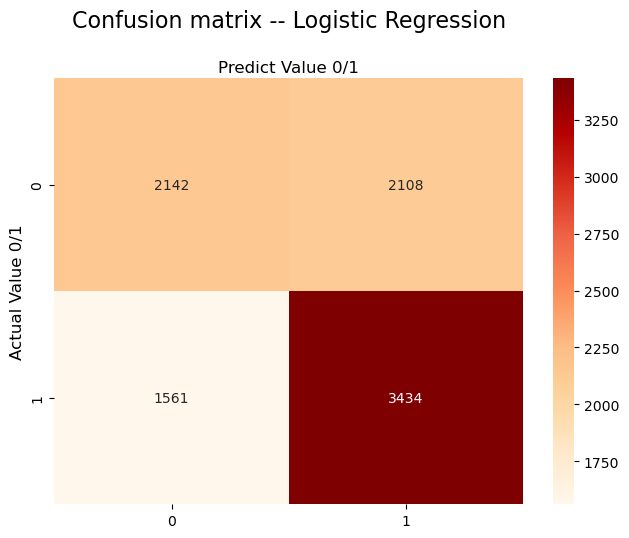

In [67]:
## Plot the matrix
def plot_cnf_matirx(cnf_matrix,description):
    class_names = [0,1]
    fig,ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks,class_names)
    plt.yticks(tick_marks,class_names)

# Create a heat map
    sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'OrRd',
               fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title(description, y = 1.1,fontsize=16)
    plt.ylabel('Actual Value 0/1',fontsize=12)
    plt.xlabel('Predict Value 0/1',fontsize=12)
    plt.show()
    
plot_cnf_matirx(cnf_matrix,'Confusion matrix -- Logistic Regression')

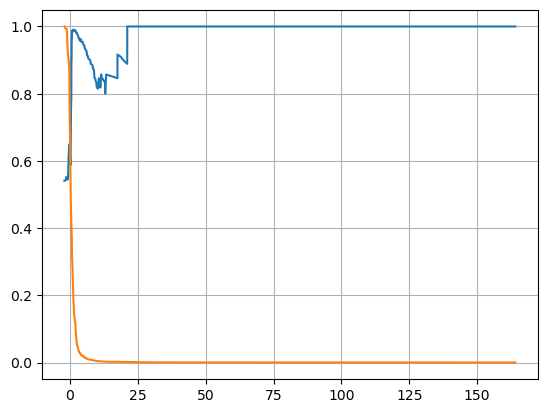

In [68]:
decision_scores = log_reg.decision_function(X_test)

from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_test,decision_scores)

plt.plot(thresholds,precisions[:-1])
plt.plot(thresholds,recalls[:-1])
plt.grid()
plt.show() 

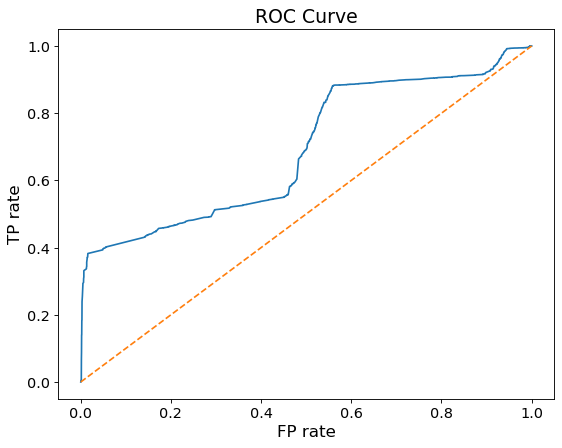

In [69]:
# Plot ROC curve
from sklearn.metrics import roc_curve

fprs,tprs,thresholds = roc_curve(y_test,decision_scores)

def plot_roc_curve(fprs,tprs):
    plt.figure(figsize=(8,6),dpi=80)
    plt.plot(fprs,tprs)
    plt.plot([0,1],linestyle='--')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('TP rate',fontsize=15)
    plt.xlabel('FP rate',fontsize=15)
    plt.title('ROC Curve',fontsize=17)
    plt.show()
    
plot_roc_curve(fprs,tprs)

In [70]:
# Get the area, which is equal to score
from sklearn.metrics import roc_auc_score 

roc_auc_score(y_test,decision_scores)

0.6915806865689218

## KNN Model

In [ ]:
param_grid = [
    {
        'weights':['uniform'],
        'n_neighbors':[i for i in range(1,31)]
    },
    {
        'weights':['distance'],
        'n_neighbors':[i for i in range(1,31)],
        'p':[i for i in range(1,6)]
    }
]
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf,param_grid)

grid_search.fit(X_train,y_train)

In [230]:
## To see the model information
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=27, p=4, weights='distance')

In [231]:
grid_search.best_score_

0.8184836122565642

In [232]:
## The score of train model
knn_clf = grid_search.best_estimator_
knn_clf.score(X_train,y_train)

0.8477986514260989

In [233]:
## The score of test model
knn_clf.score(X_test,y_test)

0.8333153055705786

In [234]:
## Get F1-score
y_predict_knn = knn_clf.predict(X_test)
f1_score(y_test,y_predict_knn)
print(classification_report(y_test,y_predict_knn))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83      4250
           1       0.87      0.81      0.84      4995

    accuracy                           0.83      9245
   macro avg       0.83      0.84      0.83      9245
weighted avg       0.84      0.83      0.83      9245



In [320]:
## The MSE or RMSE (mean square error root) is usually used to evaluate the model. 
## The smaller the value, the closer the predicted value is to the true value
from sklearn import metrics
metrics.mean_squared_error(y_test, y_predict_knn)

0.1666846944294213

In [324]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_knn}, columns=['Real','Predict']).head(10)

Real  Predict
0     0        0
1     1        0
2     1        1
3     1        1
4     1        1
5     0        0
6     0        0
7     1        1
8     1        1
9     1        0

In [235]:
## Get the matrix
cnf_matrix = confusion_matrix(y_test,y_predict_knn)
cnf_matrix

array([[3668,  582],
       [ 959, 4036]])

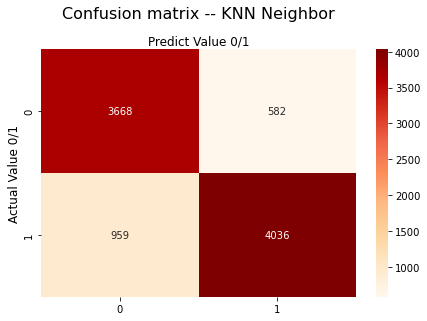

In [236]:
# Plot the matrix graph
plot_cnf_matirx(cnf_matrix,'Confusion matrix -- KNN Neighbor')

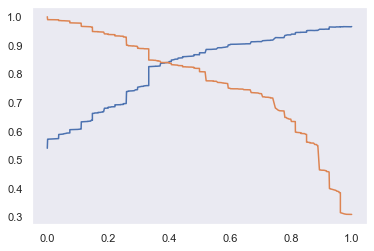

In [369]:
## Plot line graph
y_probabilities = knn_clf.predict_proba(X_test)[:,1]

from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_test,y_probabilities)

plt.plot(thresholds,precisions[:-1])
plt.plot(thresholds,recalls[:-1])
plt.grid()
plt.show()    

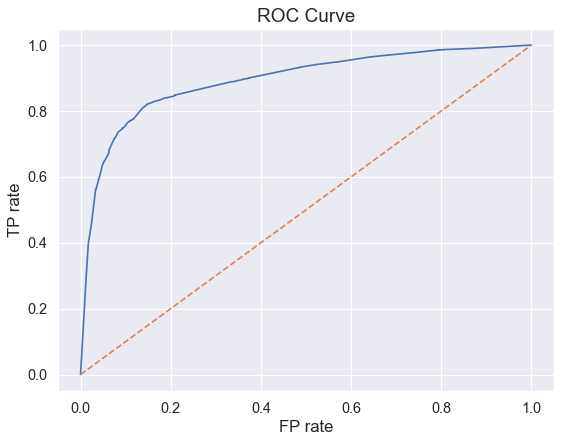

In [370]:
## Plot the ROC Curve
from sklearn.metrics import roc_curve
fprs2,tprs2,thresholds2 = roc_curve(y_test,y_probabilities)
plot_roc_curve(fprs2,tprs2)

In [239]:
# Get the area, which is equal to the score
from sklearn.metrics import roc_auc_score  
roc_auc_score(y_test,y_probabilities)

0.8926246481775892

## Decision Tree Model

In [73]:
from sklearn.tree import DecisionTreeClassifier
dt_clf= DecisionTreeClassifier(random_state=6)

In [74]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'max_features':['auto','sqrt','log2'],
        'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],
        'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]
    }
]
grid_search = GridSearchCV(dt_clf,param_grid)

grid_search.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=6),
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11],
                          'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                12, 13, 14, 15, 16, 17, 18]}])

In [143]:
from sklearn.tree import export_graphviz
export_graphviz( 
 grid_search.best_estimator_,
 out_file=('moons_tree.dot'),
 feature_names=None,
 class_names=None,
 filled=True,
)

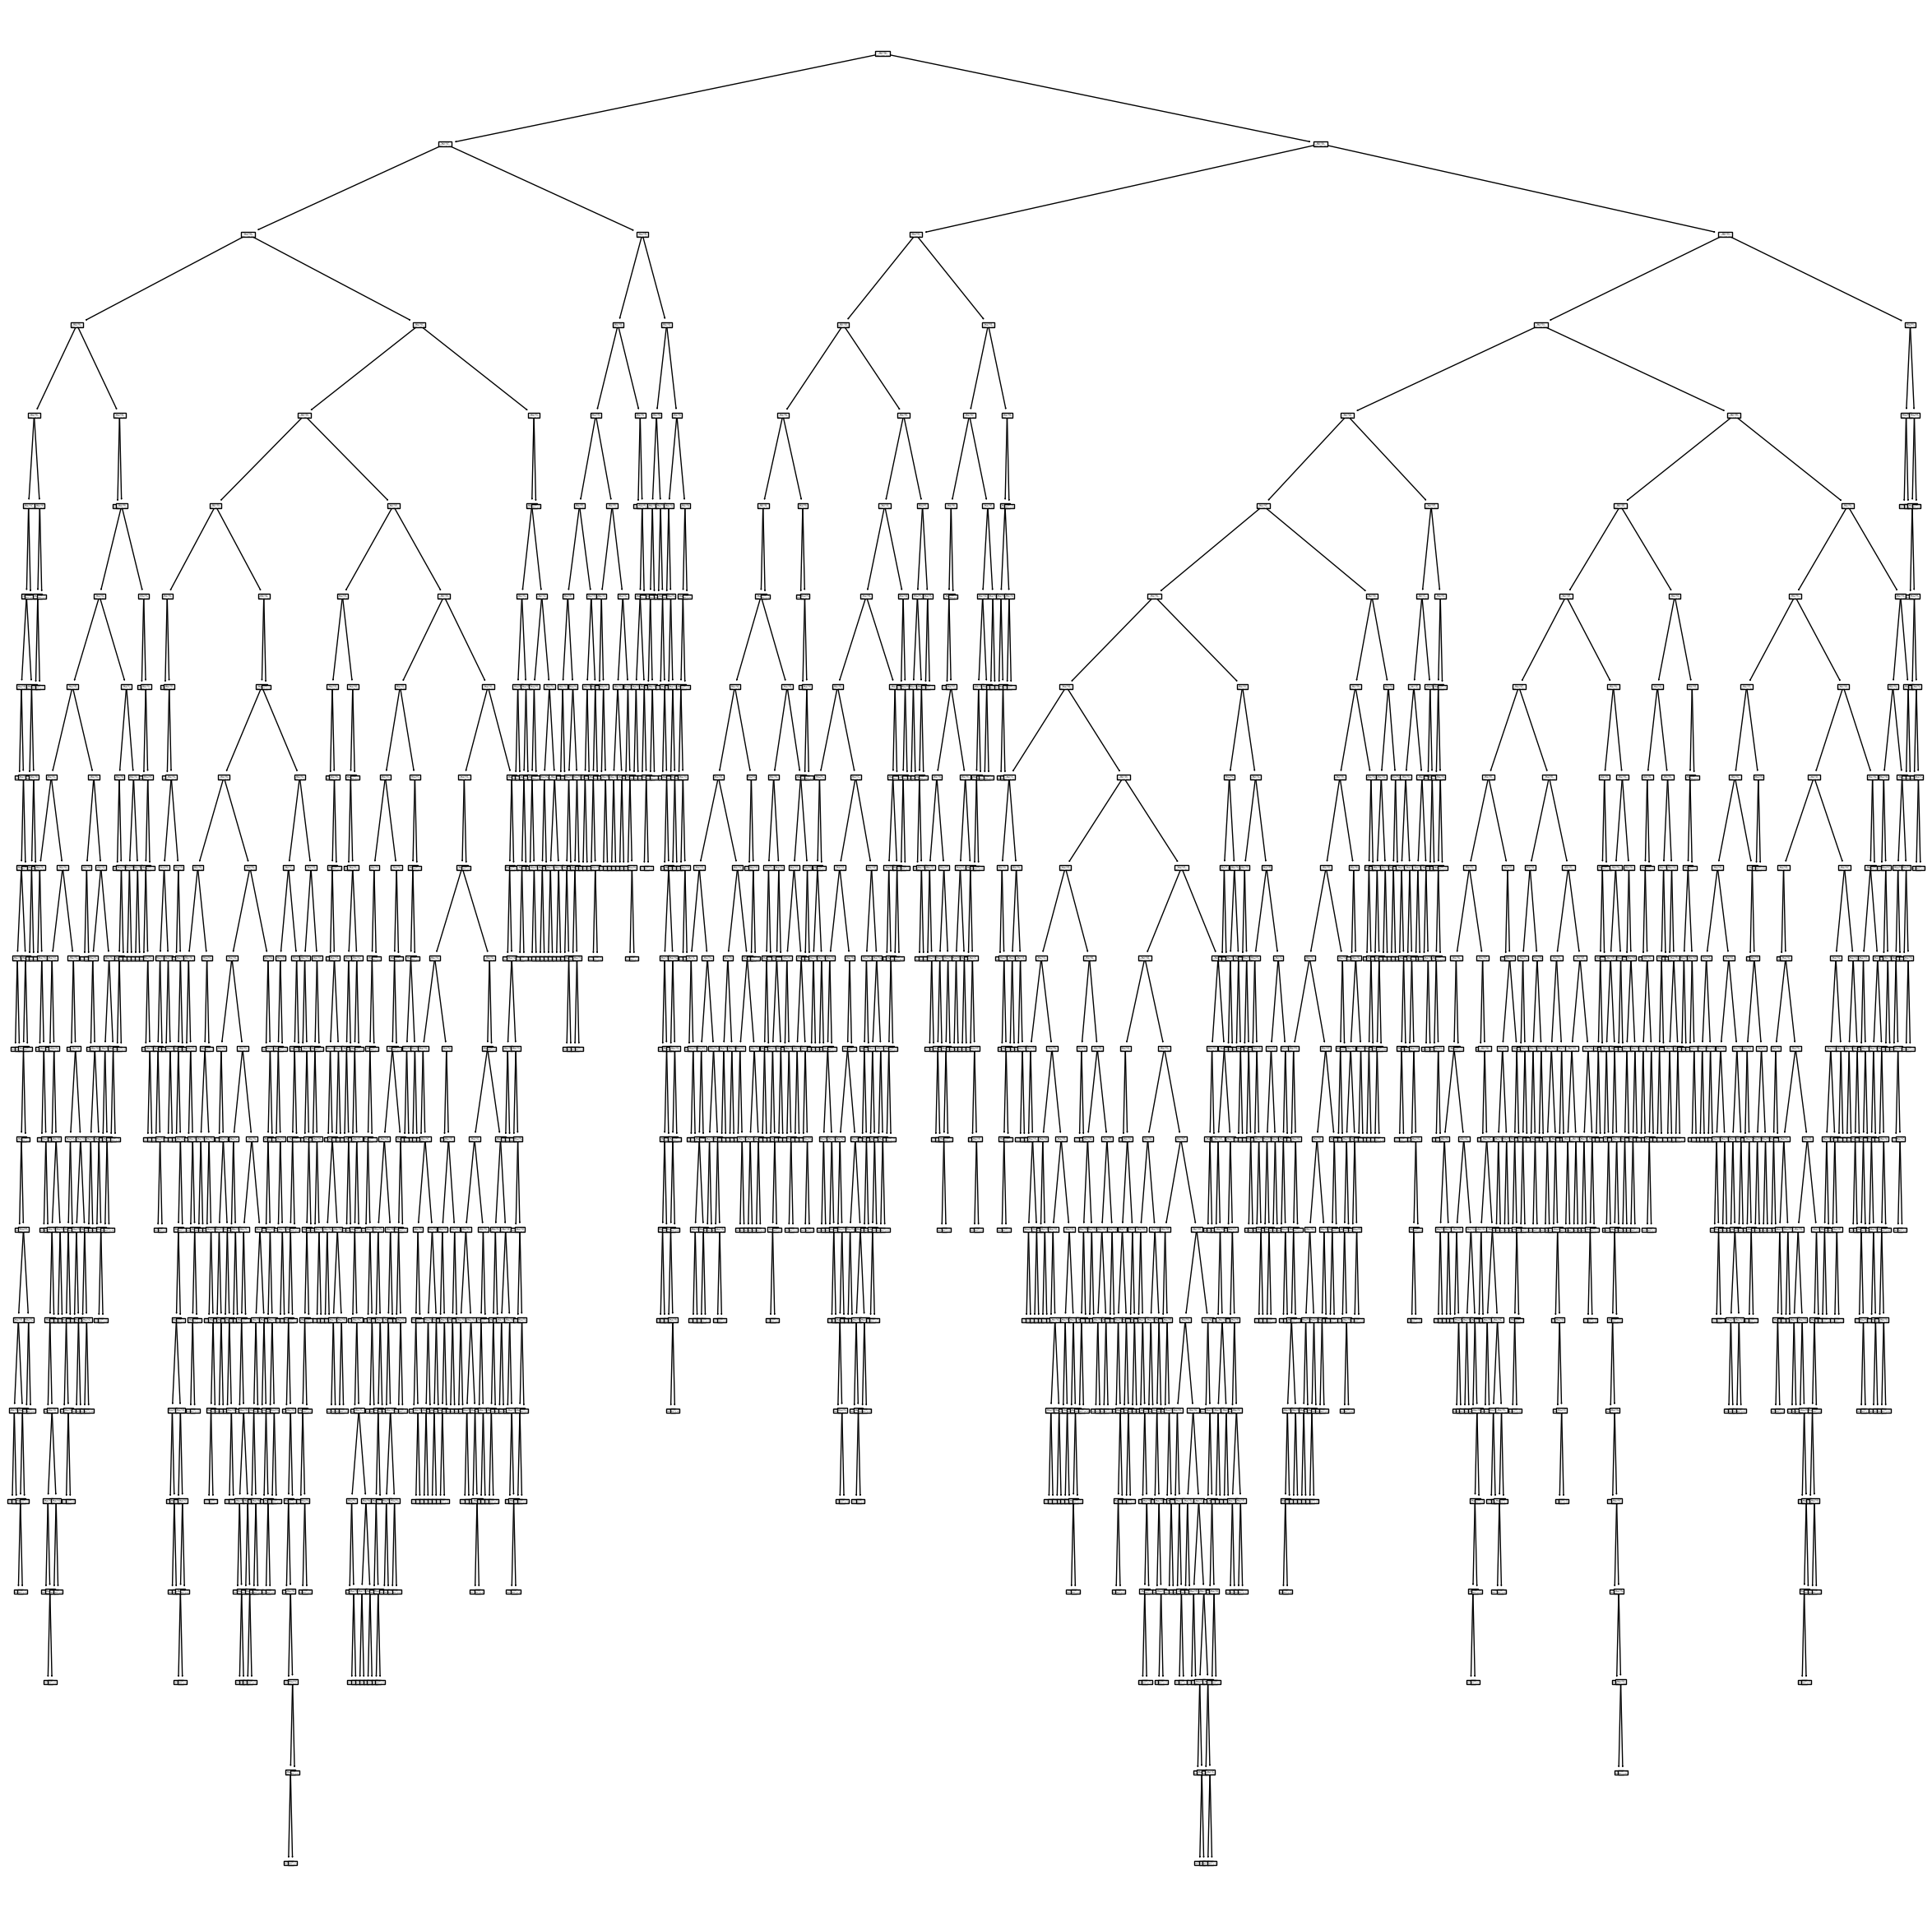

In [138]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(grid_search.best_estimator_, ax=ax)
plt.show()

In [354]:
## To see the model information
grid_search.best_estimator_

DecisionTreeClassifier(max_features='auto', min_samples_leaf=2,
                       min_samples_split=14, random_state=6)

In [355]:
grid_search.best_score_

0.8274620752236844

In [356]:
## The score of train model
dt_clf = grid_search.best_estimator_
dt_clf.score(X_train,y_train)

0.8305268092164569

In [357]:
## The score of test model
dt_clf.score(X_test,y_test)

0.826392644672796

In [358]:
## Get F1-score
y_predict_dt = dt_clf.predict(X_test)
f1_score(y_test,y_predict_dt)
print(classification_report(y_test,y_predict_dt))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      4250
           1       0.87      0.80      0.83      4995

    accuracy                           0.83      9245
   macro avg       0.83      0.83      0.83      9245
weighted avg       0.83      0.83      0.83      9245



In [359]:
## The MSE or RMSE (mean square error root) is usually used to evaluate the model. 
## The smaller the value, the closer the predicted value is to the true value
from sklearn import metrics
metrics.mean_squared_error(y_test, y_predict_dt)

0.1736073553272039

In [360]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_dt}, columns=['Real','Predict']).head(10)

Real  Predict
0     0        0
1     1        0
2     1        1
3     1        1
4     1        1
5     0        0
6     0        0
7     1        1
8     1        0
9     1        0

In [361]:
## Plot the matrix
cnf_matrix = confusion_matrix(y_test,y_predict_dt)
cnf_matrix

array([[3644,  606],
       [ 999, 3996]])

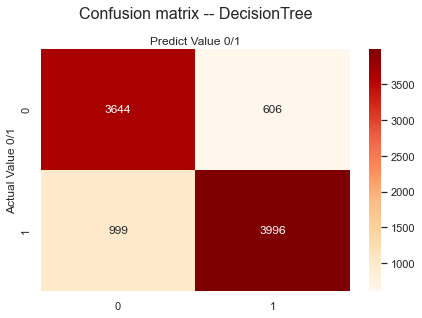

In [362]:
## Plot the heat graph
plot_cnf_matirx(cnf_matrix,'Confusion matrix -- DecisionTree')

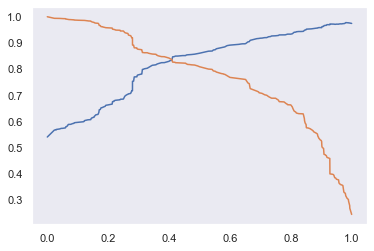

In [363]:
## Plot the line graph
y_probabilities = dt_clf.predict_proba(X_test)[:,1]

from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_test,y_probabilities)
plt.plot(thresholds,precisions[:-1])
plt.plot(thresholds,recalls[:-1])
plt.grid()
plt.show()  

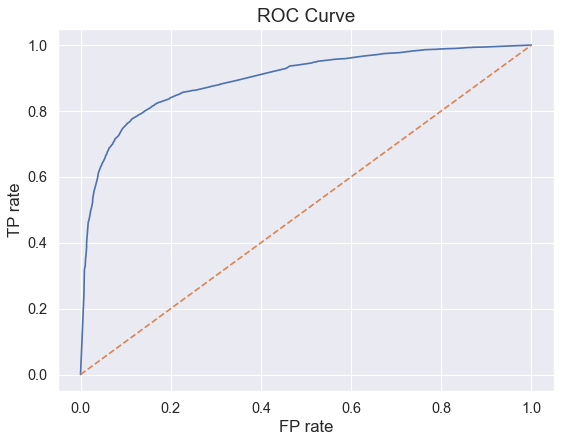

In [364]:
## Plot the ROC Curve
from sklearn.metrics import roc_curve
fprs3,tprs3,thresholds3 = roc_curve(y_test,y_probabilities)
plot_roc_curve(fprs3,tprs3)

In [365]:
# Get the area, which is equal to score
from sklearn.metrics import roc_auc_score  

roc_auc_score(y_test,y_probabilities)

0.896847883177295

In [366]:
# Get numerical feature importances
importances = list(dt_clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: senlength_derived    Importance: 0.86
Variable: is_black_derived     Importance: 0.06
Variable: is_male_derived      Importance: 0.04
Variable: his_prop             Importance: 0.02
Variable: Livability           Importance: 0.01
Variable: is_changed_offense   Importance: 0.0
Variable: is_hisp_derived      Importance: 0.0
Variable: is_white_derived     Importance: 0.0
Variable: is_judge_male        Importance: 0.0
Variable: is_covid             Importance: 0.0


## Random Forest

In [495]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10, random_state=90, oob_score=True, n_jobs=-1, min_samples_leaf = 1)
rf_clf.fit(X,y)

RandomForestClassifier(n_estimators=10, n_jobs=-1, oob_score=True,
                       random_state=90)

In [496]:
rf_clf.oob_score_

0.8278165395640651

In [497]:
## The score of train model
rf_clf.score(X_train,y_train)

0.5272058558396134

In [498]:
## The score of test model
rf_clf.score(X_test,y_test)

0.5256895619253651

In [499]:
## Get the F1-score
y_predict_rf = rf_clf.predict(X_test)
f1_score(y_test,y_predict_rf)
print(classification_report(y_test,y_predict_rf))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      4250
           1       0.99      0.12      0.22      4995

    accuracy                           0.53      9245
   macro avg       0.74      0.56      0.44      9245
weighted avg       0.76      0.53      0.42      9245



In [500]:
## The MSE or RMSE (mean square error root) is usually used to evaluate the model. 
## The smaller the value, the closer the predicted value is to the true value
from sklearn import metrics
metrics.mean_squared_error(y_test, y_predict_rf)

0.4743104380746349

In [501]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_rf}, columns=['Real','Predict']).head(10)

Real  Predict
0     0        0
1     1        0
2     1        0
3     1        0
4     1        0
5     0        0
6     0        0
7     1        1
8     1        0
9     1        0

In [502]:
## Get the matrix
cnv_matrix = confusion_matrix(y_test,y_predict_rf)
cnv_matrix

array([[4241,    9],
       [4376,  619]])

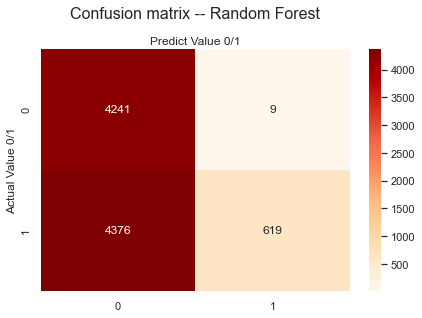

In [503]:
## Plot the heat graph
plot_cnf_matirx(cnv_matrix,'Confusion matrix -- Random Forest')

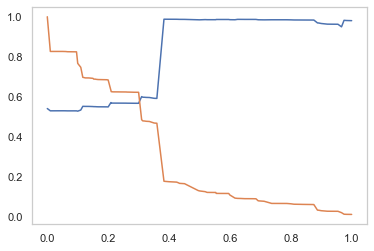

In [504]:
## Plot the line graph
y_probabilities_rf = rf_clf.predict_proba(X_test)[:,1]

from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_test,y_probabilities_rf)
plt.plot(thresholds,precisions[:-1])
plt.plot(thresholds,recalls[:-1])
plt.grid()
plt.show()   

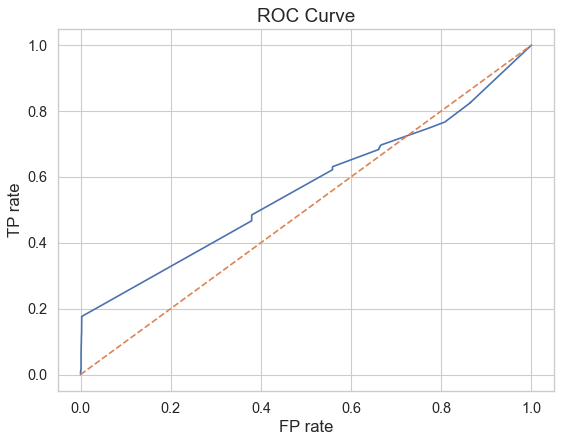

In [505]:
# Plot ROC Curve
from sklearn.metrics import roc_curve
fprs4,tprs4,thresholds4 = roc_curve(y_test,y_probabilities_rf)
plot_roc_curve(fprs4,tprs4)

In [506]:
## Get the area, which is equal to score
roc_auc_score(y_test,y_probabilities_rf)

0.563472649119708

In [507]:
# Get numerical feature importances
importances = list(rf_clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: senlength_derived    Importance: 0.85
Variable: is_black_derived     Importance: 0.03
Variable: is_male_derived      Importance: 0.03
Variable: his_prop             Importance: 0.03
Variable: Livability           Importance: 0.02
Variable: is_changed_offense   Importance: 0.01
Variable: is_hisp_derived      Importance: 0.01
Variable: is_judge_male        Importance: 0.01
Variable: is_white_derived     Importance: 0.0
Variable: is_covid             Importance: 0.0


## Refine the model through changing the random_state number

In [277]:
from sklearn.tree import DecisionTreeClassifier
dt_clf1= DecisionTreeClassifier(random_state=42)

In [278]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'max_features':['auto','sqrt','log2'],
        'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],
        'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]
    }
]
grid_search = GridSearchCV(dt_clf1,param_grid)

grid_search.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11],
                          'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                                12, 13, 14, 15, 16, 17, 18]}])

In [279]:
## The score of train model
dt_clf1 = grid_search.best_estimator_
dt_clf1.score(X_train,y_train)

0.844120722604839

In [281]:
## The score of test model
dt_clf1.score(X_test,y_test)

0.8369929691725256

In [331]:
## Get F1-score
y_predict_dt1 = dt_clf1.predict(X_test)
f1_score(y_test,y_predict_dt1)
print(classification_report(y_test,y_predict_dt))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      4250
           1       0.88      0.81      0.84      4995

    accuracy                           0.84      9245
   macro avg       0.84      0.84      0.84      9245
weighted avg       0.84      0.84      0.84      9245



In [335]:
## The MSE or RMSE (mean square error root) is usually used to evaluate the model. 
## The smaller the value, the closer the predicted value is to the true value
from sklearn import metrics
metrics.mean_squared_error(y_test, y_predict_dt1)

0.1630070308274743

In [334]:
## Compare the real value and predict value
pd.DataFrame({'Real':y_test,'Predict':y_predict_dt1}, columns=['Real','Predict']).head(10)

Real  Predict
0     0        0
1     1        0
2     1        1
3     1        1
4     1        1
5     0        0
6     0        0
7     1        1
8     1        1
9     1        0

In [336]:
## Plot the matrix
cnf_matrix1 = confusion_matrix(y_test,y_predict_dt1)
cnf_matrix1

array([[3692,  558],
       [ 949, 4046]])

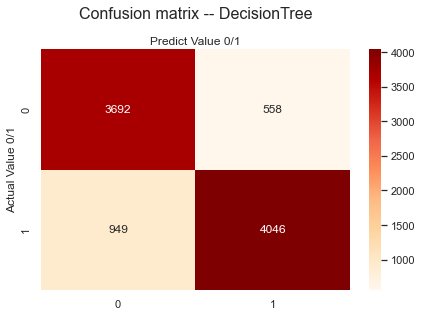

In [337]:
## Plot the heat graph
plot_cnf_matirx(cnf_matrix1,'Confusion matrix -- DecisionTree')

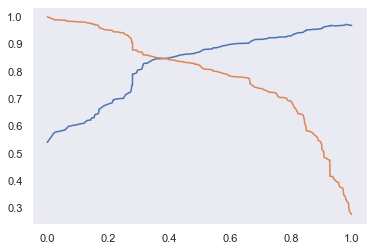

In [338]:
## Plot the line graph
y_probabilities1 = dt_clf1.predict_proba(X_test)[:,1]

from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_test,y_probabilities1)
plt.plot(thresholds,precisions[:-1])
plt.plot(thresholds,recalls[:-1])
plt.grid()
plt.show()  

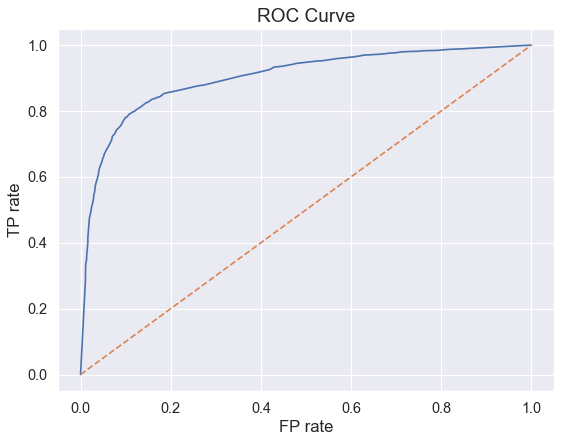

In [339]:
## Plot the ROC Curve
from sklearn.metrics import roc_curve
fprs5,tprs5,thresholds5 = roc_curve(y_test,y_probabilities1)
plot_roc_curve(fprs5,tprs5)

In [287]:
# Get the area, which is equal to score
from sklearn.metrics import roc_auc_score  

roc_auc_score(y_test,y_probabilities)

0.9017030913266206

In [288]:
# Get numerical feature importances
importances = list(dt_clf1.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: senlength_derived    Importance: 0.86
Variable: is_male_derived      Importance: 0.04
Variable: is_black_derived     Importance: 0.03
Variable: his_prop             Importance: 0.03
Variable: Livability           Importance: 0.02
Variable: is_judge_male        Importance: 0.01
Variable: is_changed_offense   Importance: 0.0
Variable: is_hisp_derived      Importance: 0.0
Variable: is_white_derived     Importance: 0.0
Variable: is_covid             Importance: 0.0


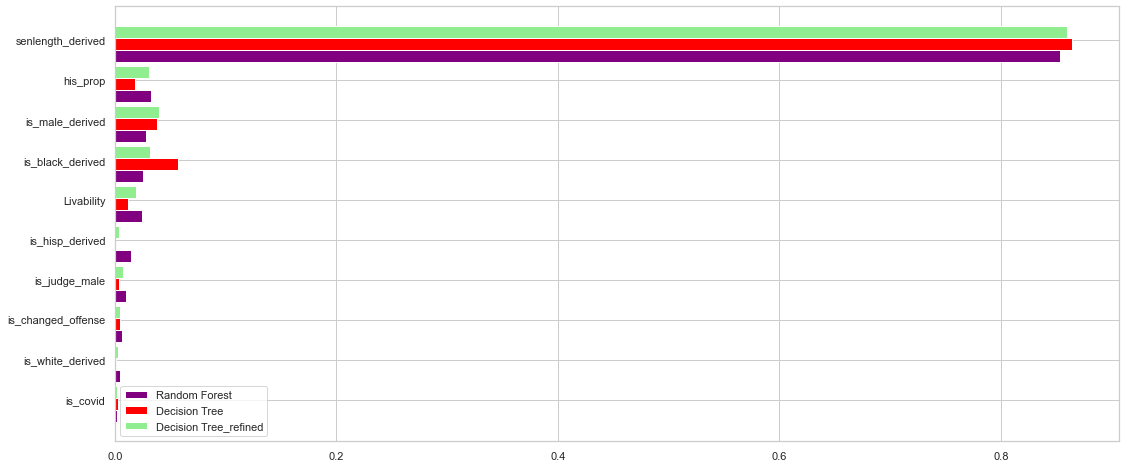

In [514]:
## Compare the feature importances of Random Forest and Decision Tree
feature_importance1=pd.DataFrame({
    'rfc':rf_clf.feature_importances_,
    'dt':dt_clf.feature_importances_,
    'dt_refine':dt_clf1.feature_importances_
},index=sentencing_concat.drop(['Incar'], axis = 1).columns)
feature_importance1.sort_values(by='rfc',ascending=True,inplace=True)

index = np.arange(len(feature_importance1))
fig, ax = plt.subplots(figsize=(18,8))
rfc_feature=ax.barh(index,feature_importance1['rfc'],0.3,color='purple',label='Random Forest')
dt_feature=ax.barh(index+0.3,feature_importance1['dt'],0.3,color='red',label='Decision Tree')
dt_refine_feature=ax.barh(index+0.6,feature_importance1['dt_refine'],0.3,color='lightgreen',label='Decision Tree_refined')
ax.set(yticks=index+0.4,yticklabels=feature_importance1.index)

ax.legend()
plt.show()

## Plot these ROC Curve together

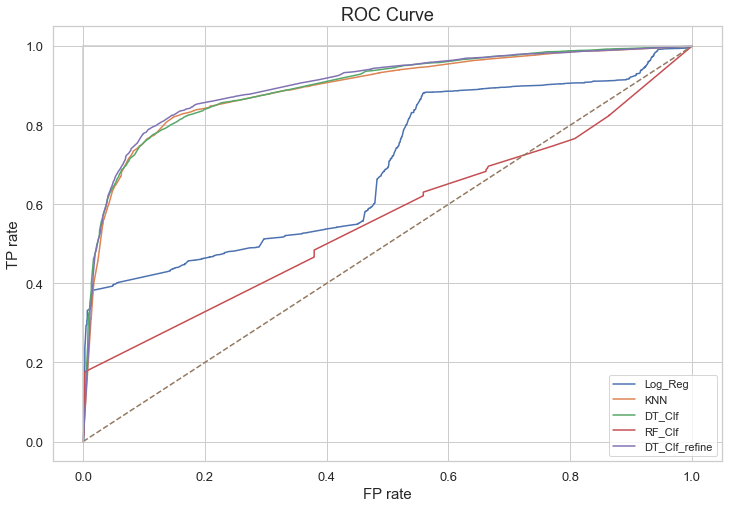

In [508]:
## Plot these curve together
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
plt.title('ROC Curve',fontsize=18)
plt.plot(fprs,tprs,label='Log_Reg')
plt.plot(fprs2,tprs2,label='KNN')
plt.plot(fprs3,tprs3,label='DT_Clf')
plt.plot(fprs4,tprs4,label='RF_Clf')
plt.plot(fprs5,tprs5,label='DT_Clf_refine')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.8')
plt.plot([1,1],c='.8')
plt.ylabel('TP rate',fontsize=15)
plt.xlabel('FP rate',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.show()